In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2. Đọc file dữ liệu chứng khoán XOM
df_input = pd.read_csv('/content/drive/MyDrive/StockData/VLO.csv')

# 3. Đọc file dữ liệu trên tập dữ liệu dùng làm biến ngoại sinh (exogenous)
df_exo = pd.read_csv('/content/drive/MyDrive/StockData/DCOILWTICO.csv')

In [4]:
# Đổi tên các cột DATE và DCOILWTICO
df_exo = df_exo.rename(columns={'DATE': 'Date', 'DCOILWTICO': 'WTI Price'})

# Chỉ lưu giữ các dòng trong df_exo có mà df_xom cũng có dựa trên cột ngày
df_exo = df_exo[df_exo['Date'].isin(df_input['Date'])]

# Thay thế các ô có giá trị '.' bằng NaN
df_exo.replace('.', np.nan, inplace=True)

# Chuyển đổi kiểu dữ liệu của cột 'WTI Price' thành float64
df_exo['WTI Price'] = df_exo['WTI Price'].astype(float)

# Tính giá trị trung bình của cột 'WTI Price'
mean_value = df_exo['WTI Price'].mean()

# Thay thế các NaN bằng giá trị trung bình
df_exo['WTI Price'].fillna(mean_value, inplace=True)

In [5]:
df = pd.merge(df_input, df_exo, on='Date')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,WTI Price
0,2018-01-02,92.190002,93.139999,91.709999,92.800003,72.733246,3582900,60.37
1,2018-01-03,92.580002,93.470001,92.500000,93.290001,73.117287,3057600,61.61
2,2018-01-04,93.410004,93.620003,92.639999,93.589996,73.352409,2977000,61.98
3,2018-01-05,93.599998,94.300003,93.430000,94.029999,73.697281,2973800,61.49
4,2018-01-08,94.129997,94.370003,93.400002,94.220001,73.846191,2493400,61.73
5,2018-01-09,94.760002,94.959999,94.000000,94.099998,73.752144,3884900,62.92
6,2018-01-10,93.809998,94.650002,93.559998,94.150002,73.791344,2391800,63.60
7,2018-01-11,94.589996,94.610001,93.610001,94.550003,74.104836,2679700,63.81
8,2018-01-12,94.910004,97.000000,94.709999,96.750000,75.829109,2873400,64.22
9,2018-01-16,96.849998,97.550003,95.660004,96.150002,75.358849,3052500,63.82


In [6]:
# 4. Chia train test validate theo tỉ lệ 6:2:2
df = df[['Close', 'WTI Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print(len(train_data))
print(len(test_data))
print(len(val_data))

801
267
268


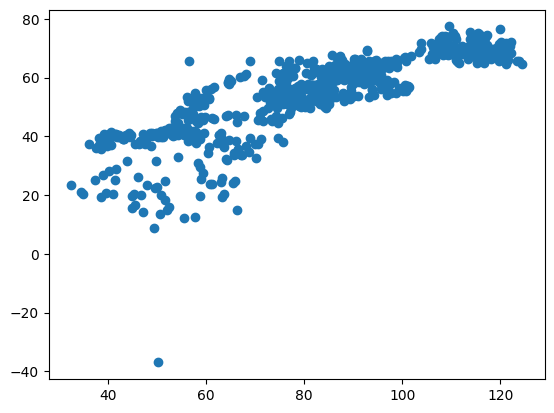

In [7]:
exo_arr = np.array(train_data['WTI Price'])
data_arr = np.array(train_data['Close'])
# vẽ biểu đồ scatter plot để xem sự tương quan giữa giá cổ phiếu XOM và giá trị biến ngoại sinh
plt.scatter(x = data_arr, y = exo_arr)
plt.show()

In [8]:
# Tìm hệ số tương quan giữa 2 cột Close và giá trị biến ngoại sinh
correlation = np.corrcoef(data_arr, exo_arr)[0, 1]

# In kết quả
print("Hệ số tương quan: ", correlation)

Hệ số tương quan:  0.8364632305949692


In [9]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00


In [10]:
# 3. Quá trình Training
train_exo = train_data[["WTI Price"]]

# Sử dụng auto_arima kèm biến ngoại sinh tìm ra model tốt nhất
from pmdarima.arima import auto_arima
model = auto_arima(train_data['Close'],
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      exogenous= train_exo)

# Gán các giá trị p, d, q vào các biến tương ứng
p = model.order[0]
d = model.order[1]
q = model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3398.880, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3398.141, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3399.566, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3399.606, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3396.222, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3401.301, Time=0.65 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.899 seconds


In [11]:
# Khởi tạo mô hình ARIMAX với order=(p, d, q) và khai báo biến ngoại sinh
model= SARIMAX(train_data['Close'],
 exog=train_exo,
 order=(p,d,q),
 enforce_invertibility=False, enforce_stationarity=False)

# Fit mô hình bằng dữ liệu huấn luyện để tìm ra các giá trị tối ưu cho các tham số của mô hình
model = model.fit()

In [12]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exo = test_data[['WTI Price']]
y_pred = model.forecast(steps=len(y_test), exog=test_exo)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exo = val_data[['WTI Price']]
y_pred_val =  model.forecast(steps=len(y_val), exog=val_exo)

In [13]:
# 6. Đánh giá độ chính xác thuật toán bằng RMSE
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val))
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred))

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 46.10468293763784
Testing RMSE: 7.675248266646902
Validation MAPE: 35.589938116157924
Testing MAPE: 8.640210323879227
Validation MDA: 67.79026217228464
Testing MDA: 65.78947368421053


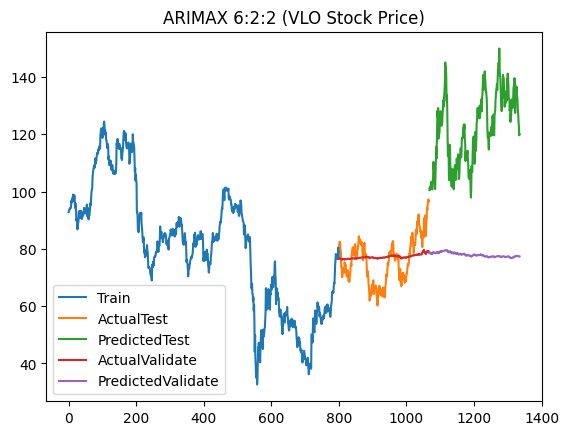

In [14]:
# 7.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.legend(['Train', 'ActualTest', 'PredictedTest','ActualValidate', 'PredictedValidate'])
plt.title('ARIMAX 6:2:2 (VLO Stock Price)')
plt.show()